In [ ]:
#Comprendre le comportement des utilisateurs du site et prédire leurs comportements futurs
#comment naviguent-ils sur le site?
#quelle est la proportion de produits achetés/vus/ajoutés au panier
#observons nous des pics d'acahat sur un mois en particulier?
#quelles sont les catégories de produits qui ont le plus d'event (vu/ajoutés/achetés)
#Faire des prédictions sur le nbre d'articles qui sera vu/ajoutés/achetés

#Exploration des variables du jeu de données (cf rapport exploration)
#https://docs.google.com/spreadsheets/d/1VZso0YxKMKwFEfGvL84nlnbTWFWUShdzd1ZpW5mzCpo/edit#gid=0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px



In [ ]:
#Exploration des datasets

In [ ]:
copied_path = 'drive/MyDrive/Projet E commerce DA 23-24/item_properties_part1.csv' #remove ‘content/’ from path then use
df_it_prop1= pd.read_csv(copied_path)
display(df_it_prop1.head(5))
print(df_it_prop1.shape)

,timestamp,itemid,property,value
0,1431226800000,59481,790,n15360.000
1,1431831600000,156781,917,828513
2,1431831600000,264312,6,319724
3,1434250800000,98113,451,1141052 n48.000
4,1437274800000,186518,available,0


(2520260, 4)


In [ ]:
copied_path = 'drive/MyDrive/Projet E commerce DA 23-24/item_properties_part2.csv' #remove ‘content/’ from path then use
df_it_prop2= pd.read_csv(copied_path)
display(df_it_prop2.head(5))
df_it_prop2.dtypes
print(df_it_prop2.shape)


,timestamp,itemid,property,value
0,1438484400000,256368,888,437265 1296497 n24.000 229949 651738 285933
1,1431831600000,430773,283,257131 82777 493871 n27636.000 906078 939413
2,1435460400000,381893,790,n230280.000
3,1439694000000,112867,364,245911
4,1441508400000,281368,888,162712 866993 806659 370498 1297729 n12.000 90...


(2115992, 4)


In [ ]:
# concaténation des 2 tables properties
item=pd.concat([df_it_prop1,df_it_prop2], axis=0)

In [ ]:
# Nbre de lignes et vérification valeurs manquantes et doublons
print("Nombre de lignes dans item:", item.shape[0])
print("Pourcentage de valeurs manquantes dans les variables de item")
display(pd.DataFrame(index=item.columns, columns=['%_valeurs_manquantes'], data= (item.isna().sum().values / len(item)*100)))
print("Doublons")
display(item.duplicated().sum())

Nombre de lignes dans item: 4636252
Pourcentage de valeurs manquantes dans les variables de item


,%_valeurs_manquantes
timestamp,0.0
itemid,0.0
property,0.0
value,0.0


Doublons


0

In [ ]:
#nbre d'itemid dans item
liste_itemid_item=item.itemid.unique()
display(liste_itemid_item)
print("Nbre itemid dans item")
display(len(liste_itemid_item))

array([ 59481, 156781, 264312, ..., 206723, 352709, 170360])

Nbre itemid dans item


76470

In [ ]:
copied_path = 'drive/MyDrive/Projet E commerce DA 23-24/events.csv' #remove ‘content/’ from path then use
df= pd.read_csv(copied_path)
display(df.head(5))
display(len(df))

,timestamp,visitorid,event,itemid,transactionid
0,1435378983392,389525,view,187002,NaN
1,1432580061072,1179879,view,341578,NaN
2,1431732489334,958126,view,328966,NaN
3,1441164669677,527666,view,212144,NaN
4,1440180907132,1019714,view,153033,NaN


275610

In [ ]:
#nbre d'itemid dans df
liste_itemid_df=df['itemid'].unique()
display(liste_itemid_df)
print("Nbre itemid dans item")
display(len(liste_itemid_df))

array([187002, 341578, 328966, ..., 438862, 108149, 218856])

Nbre itemid dans item


90424

In [ ]:
#rechercher les itemsid qui sont dans item mais egalement dans df
#liste_itemid_commun=[]
#for i in liste_itemid_item:
 # for j in liste_itemid_df:
   # if i == j:
    #  liste_itemid_commun.append(i)

#print(liste_itemid_commun)

In [ ]:
#tous les itemid présents dans item sont également présents dans df

In [ ]:
#filtrage de df avec les itemid commun à item et df
df=df.loc[df['itemid'].isin(liste_itemid_item)]
df=df.reset_index(drop=True)
display(len(df))

249726

In [ ]:
#seules les informations sur la disponibilité ou non du produit ainsi que la catégorie du produit peuvent nous être utiles dans item
#création de 2 df item_ availability et item_categ
item_availability=item.loc[item.property=='available']
item_category=item.loc[item.property=='categoryid']

In [ ]:
item_category=item_category.reset_index(drop=True)
item_availability=item_availability.reset_index(drop=True)
display(item_availability.head())
display(item_category.head())

,timestamp,itemid,property,value
0,1437274800000,186518,available,0
1,1437274800000,430459,available,0
2,1433041200000,411262,available,0
3,1441508400000,289043,available,0
4,1435460400000,365407,available,0


,timestamp,itemid,property,value
0,1435460400000,35575,categoryid,1059
1,1441508400000,76417,categoryid,1244
2,1433041200000,96660,categoryid,498
3,1441508400000,244437,categoryid,438
4,1438484400000,313481,categoryid,1613


In [ ]:
display(len(item_category))
display(len(item_availability))

167443

545175

In [ ]:
#fusion de df avec item_availability pour récupérer les infos sur la disponibilité de nos produits
#nous utiliserons ici merge asof qui nous permettra de récupérer la disponibilité du produit à peu près au moment où l'event a été réalisé
#création merged_1

item_availability.itemid = item_availability.itemid.astype('int64')

merged_1=pd.merge_asof(df.sort_values('timestamp'),item_availability.sort_values('timestamp'),by='itemid', on='timestamp',direction='nearest')
merged_1.head()


,timestamp,visitorid,event,itemid,transactionid,property,value
0,1430622027031,1149227,view,29757,NaN,available,1
1,1430622028399,477106,view,297347,NaN,available,0
2,1430622036210,654913,view,149767,NaN,available,1
3,1430622115328,375734,view,282298,NaN,available,1
4,1430622118534,584571,view,436195,NaN,available,1


In [ ]:
#création merged_2 pour récupérer à présent les categories de certains produits

item_category.itemid = item_category.itemid.astype('int64')

merged_2=pd.merge_asof(merged_1.sort_values('timestamp'),item_category.sort_values('timestamp'),by='itemid', on='timestamp',direction='nearest')
merged_2.head()

,timestamp,visitorid,event,itemid,transactionid,property_x,value_x,property_y,value_y
0,1430622027031,1149227,view,29757,NaN,available,1,categoryid,858
1,1430622028399,477106,view,297347,NaN,available,0,categoryid,1674
2,1430622036210,654913,view,149767,NaN,available,1,categoryid,368
3,1430622115328,375734,view,282298,NaN,available,1,categoryid,1613
4,1430622118534,584571,view,436195,NaN,available,1,categoryid,1090


In [ ]:
#suppression des colonnes property et transactionid
merged_2=merged_2.drop(['property_x','property_y','transactionid'], axis=1)

In [ ]:
#renommer les colonnes pour plus de clarté
merged_2=merged_2.rename(columns={'value_x': "available", "value_y": "categoryid"})
merged_2.head()

,timestamp,visitorid,event,itemid,available,categoryid
0,1430622027031,1149227,view,29757,1,858
1,1430622028399,477106,view,297347,0,1674
2,1430622036210,654913,view,149767,1,368
3,1430622115328,375734,view,282298,1,1613
4,1430622118534,584571,view,436195,1,1090


In [ ]:
merged_2.isna().sum()

timestamp     0
visitorid     0
event         0
itemid        0
available     0
categoryid    0
dtype: int64

In [ ]:
merged_2.categoryid=merged_2.categoryid.astype(int)
merged_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249726 entries, 0 to 249725
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   timestamp   249726 non-null  int64 
 1   visitorid   249726 non-null  int64 
 2   event       249726 non-null  object
 3   itemid      249726 non-null  int64 
 4   available   249726 non-null  object
 5   categoryid  249726 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.3+ MB


In [ ]:
copied_path = 'drive/MyDrive/Projet E commerce DA 23-24/category_tree.csv' #remove ‘content/’ from path then use
tree= pd.read_csv(copied_path)
display(tree.head(5))

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [ ]:
# Nbre de lignes et valeurs manquantes category
print("Nombre de lignes dans category_tree:", tree.shape[0])
print("Pourcentage de valeurs manquantes dans les variables de category_tree")
pd.DataFrame(index=tree.columns, columns=['%_valeurs_manquantes'], data= (tree.isna().sum().values / len(tree)*100))

Nombre de lignes dans category_tree: 1669
Pourcentage de valeurs manquantes dans les variables de category_tree


,%_valeurs_manquantes
categoryid,0.000000
parentid,1.497903


In [ ]:
# Vérification de doublons
tree.duplicated().sum()

0

In [ ]:
#nous allons à présent récuperer les informations sur les parentid correspondant à nos catégories dans tree
df_final=merged_2.merge(tree, how='left', on= 'categoryid')

In [ ]:
#création de 3 nouvelles variables à partir de la colonne event
df_final=df_final.join(pd.get_dummies(data=df_final['event']))

In [ ]:
# conversion en datetime de timestamp
df_final['timestamp'] = pd.to_datetime(df_final['timestamp'], unit='ms')
# Créer la Colonne Mois
df_final['month'] = df_final['timestamp'].dt.month

In [ ]:
display(df_final.head())
display(df_final.shape)

,timestamp,visitorid,event,itemid,available,categoryid,parentid,addtocart,transaction,view,month
0,2015-05-03 03:00:27.031,1149227,view,29757,1,858,1426.0,0,0,1,5
1,2015-05-03 03:00:28.399,477106,view,297347,0,1674,1420.0,0,0,1,5
2,2015-05-03 03:00:36.210,654913,view,149767,1,368,901.0,0,0,1,5
3,2015-05-03 03:01:55.328,375734,view,282298,1,1613,250.0,0,0,1,5
4,2015-05-03 03:01:58.534,584571,view,436195,1,1090,648.0,0,0,1,5


(249726, 11)

In [ ]:
#Vérification NaN, duplicated, types col
display(pd.DataFrame(index=df_final.columns, columns=['%_valeurs_manquantes'], data= (df_final.isna().sum().values / len(item)*100)))
print("Doublons")
display(df_final.duplicated().sum())
print("Types des variables")
display(df_final.dtypes)

,%_valeurs_manquantes
timestamp,0.000000
visitorid,0.000000
event,0.000000
itemid,0.000000
available,0.000000
categoryid,0.000000
parentid,0.000022
addtocart,0.000000
transaction,0.000000
view,0.000000


Doublons


5

Types des variables


timestamp      datetime64[ns]
visitorid               int64
event                  object
itemid                  int64
available              object
categoryid              int64
parentid              float64
addtocart               uint8
transaction             uint8
view                    uint8
month                   int64
dtype: object

In [ ]:
#Remplacement des fillna de parentid par 9999 qui correspond à Other
df_final['parentid'].fillna(9999, inplace=True)

In [ ]:
# Conversion des variables
df_final[['available','parentid','addtocart','transaction','view']]=df_final[['available','parentid','addtocart','transaction','view']].astype(int)


In [ ]:
#aperçu des doublons
duplicates_df_final = df_final[df_final.duplicated(keep=False)]
display(duplicates_df_final)
#suppression doublons car ils sont identiques
df_final=df_final.drop_duplicates()

,timestamp,visitorid,event,itemid,available,categoryid,parentid,addtocart,transaction,view,month
122572,2015-07-08 05:33:01.491,1068724,view,139207,1,161,351,0,0,1,7
122573,2015-07-08 05:33:01.491,1068724,view,139207,1,161,351,0,0,1,7
164659,2015-07-27 22:15:19.816,760596,addtocart,266900,1,1650,1426,1,0,0,7
164660,2015-07-27 22:15:19.816,760596,addtocart,266900,1,1650,1426,1,0,0,7
185446,2015-08-08 21:26:22.938,1365939,addtocart,17419,1,499,986,1,0,0,8
185447,2015-08-08 21:26:22.938,1365939,addtocart,17419,1,499,986,1,0,0,8
200400,2015-08-18 13:37:52.199,1321861,view,273872,1,535,426,0,0,1,8
200401,2015-08-18 13:37:52.199,1321861,view,273872,1,535,426,0,0,1,8
226002,2015-09-03 05:54:31.712,1241373,addtocart,191763,1,1222,105,1,0,0,9
226003,2015-09-03 05:54:31.712,1241373,addtocart,191763,1,1222,105,1,0,0,9


In [ ]:
df_final=df_final.drop(['event','timestamp'], axis=1)

In [ ]:
display(df_final.head())
display(df_final.shape)

,visitorid,itemid,available,categoryid,parentid,addtocart,transaction,view,month
0,1149227,29757,1,858,1426,0,0,1,5
1,477106,297347,0,1674,1420,0,0,1,5
2,654913,149767,1,368,901,0,0,1,5
3,375734,282298,1,1613,250,0,0,1,5
4,584571,436195,1,1090,648,0,0,1,5


(249721, 9)

In [ ]:
#agreger les données
dictag={'addtocart':'sum','transaction':'sum','view':'sum','available':'last','categoryid':'first','parentid':'first','month':'nunique','visitorid':'nunique' }
df_final_ag=df_final.groupby('itemid').agg(dictag)

In [ ]:
#Faire un groupby item_id et appliquer une agrégation sur les variables
#"addtocart" -> somme
#"transaction" -> somme
#"view" -> somme
#"available" -> garder que la dernière valeur
#"categoryid" -> garder la première valeur
#"parentid" -> garder la première valeur
#"month"-> garder le nombre de mois unique
#"visitorid"-> garder le nombre de visiteurs uniques qui ont consulté le produit

In [ ]:
display(df_final_ag.head())
display(df_final_ag.shape)
#variable cible: Transaction

,addtocart,transaction,view,available,categoryid,parentid,month,visitorid
itemid,,,,,,,,
6,0,0,3,0,1091,573,2,3
16,0,0,4,1,333,1497,4,4
19,0,0,1,1,1171,938,1,1
25,0,0,3,1,1509,620,2,3
32,0,0,6,0,1173,805,5,6


(76470, 8)

In [ ]:
#variables numériques: addcart,transaction,view,visitorid, month
#variables catégorielles:available,category,parentid

In [ ]:
df_final_ag.describe()

,addtocart,transaction,view,available,categoryid,parentid,month,visitorid
count,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000,76470.000000
mean,0.088139,0.028822,3.148647,0.428312,885.904695,859.310566,1.753812,3.107245
std,0.429800,0.227693,5.846591,0.494837,482.777599,503.102014,1.092687,5.723524
min,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,0.000000,461.000000,441.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,959.000000,871.000000,1.000000,1.000000
75%,0.000000,0.000000,3.000000,1.000000,1279.000000,1329.000000,2.000000,3.000000
max,39.000000,26.000000,348.000000,1.000000,1697.000000,9999.000000,5.000000,343.000000


In [ ]:
#Datavizualisation

In [ ]:
#idées de visualisation pour comprendre les habitudes de navigation sur le site:
#Axe 1) une visualisation descriptive des données
#Distribution du nbre de vu/add/transaction des produits
#Distribution du nbre de visiteurs pour un produit
#quelle est la proportion de produits disponible/non disponible? =>sns.countplot available
#le nbre de mois unique ?=>sns.countplot month
#quelles sont les 10 categ qui réalisent des events?


#Axe 2) impacte des différents facteurs sur les events
#est-ce qu'il y a un lien entre la disponibilité ou non du produits et les vus?=> sns.catplot nuage de point ou violin par exemple (disponibilité vs view)
#relation entre le nbre de visiteur du produit et la transaction=> sns.lmplot
#Axe 3) correlations
#correlation variables numerique()

In [ ]:
#Distribution du nbre de vu/add/transaction des produits
#sur la période considérée, la plupart des produits ont été vu une fois, certains entre 2 et 5 fois
#Très peu ont été ajoutés et parmis ceux-ci, le nbre d'ajout de produits est de 1 voir 2
#Il en est de même pour les transactions, une seule transaction
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3,
                   subplot_titles = ['Distribution des views','Distribution des ajouts paniers','Distribution des transactions'])

fig.add_trace(go.Histogram(x=df_final_ag['view'],
                           marker_color = 'blue',
                           name='View',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict( # bins used for histogram
                            start=0,
                             end=30,
                             size=1)),
                           1,1)

fig.add_trace(go.Histogram(x=df_final_ag['addtocart'],
                           marker_color = 'orange',
                           name='Ajout panier',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict(
                            start=0,
                             end=10,
                             size=1)),
                           1,2)

fig.add_trace(go.Histogram(x=df_final_ag['transaction'],
                           marker_color = 'green',
                           name='Transaction',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict(
                            start=0,
                             end=10,
                             size=0.5)),
                           1,3)


In [ ]:
#Distribution du nbre de visiteurs pour un produit
fig=go.Figure()
fig.add_trace(go.Histogram(x=df_final_ag['visitorid'],
                           marker_color = 'blue',
                           name='Nbre de visiteurs',
                           marker_line = dict(width = 1, color = 'white'),
                           xbins=dict( # bins used for histogram
                            start=0,
                             end=20,
                             size=1)))

In [ ]:
values=df_final.month.value_counts()
values2=df_final_ag.month.value_counts()
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type':'domain'}, {'type':'domain'}]],
                   subplot_titles = ['Répartition des mois','Nbre de mois unique'])

fig.add_trace(go.Pie(values=values.values,
                     labels=values.index,
                     pull = [0.1,0,0,0,0],
                     legendgroup="group1",
                     legendgrouptitle_text = " Mois"),
                     1,1)
fig.add_trace(go.Pie(values=values2.values,
                     labels=values2.index,
                     pull = [0.1,0,0,0,0],
                     legendgroup="group2",
                     legendgrouptitle_text = "Mois unique"),
                     1,2)
fig.show()
#la période de juin à juillet semble être la période qui a le plus d'evènement, contrairement au mois de septembre
#le nbre de mois unique où un produit est consulté ou acheté est de généralement de 1 voir 2 (donc un cycle d'achat relativement court)

In [ ]:
#quelle est la proportion de produits disponible/non disponible?
#sur la période considérée, nous avons un peu plus de produits indisponibles en comparaison aux produits disponibles,
#ce qui a dû influencer la non réalisation des transactions sur le site
values=df_final_ag.available.astype(str).value_counts()
fig=go.Figure([go.Bar(x=values.index,
                      y = values)])

fig.update_layout(title = 'La disponibilité des produits',
                 xaxis_title = 'Available',
                 yaxis_title = 'Count')

In [ ]:
topview=df_final_ag.sort_values(by='view', ascending=False).head(10)
topadd=df_final_ag.sort_values(by='addtocart', ascending=False).head(10)
toptrans=df_final_ag.sort_values(by='transaction', ascending=False).head(10)
topview.categoryid=topview.categoryid.astype(str)
topadd.categoryid=topadd.categoryid.astype(str)
toptrans.categoryid=toptrans.categoryid.astype(str)

fig2 = make_subplots(rows=1, cols=3,
                   subplot_titles = ['Top catégorie view','Top catégorie ajouts paniers','Top catégorie transactions'])

fig2.add_trace(go.Bar(x=topview.categoryid,
                      y = topview['view'],
                      name='View'),
                      1,1)
fig2.add_trace(go.Bar(x=topadd.categoryid,
                      y = topadd['addtocart'],
                      name='Addtocart'),
                      1,2)
fig2.add_trace(go.Bar(x=toptrans.categoryid,
                      y = toptrans['transaction'],
                      name='Transaction'),
                      1,3)



In [ ]:
#relation entre le nbre de vus et les ajouts au panier
#relation entre les ajouts et les transactions
fig3 = make_subplots(rows=1, cols=3,
                   subplot_titles = ['Relation vus vs ajout panier','Relation ajout panier et transaction','Relation visiteurs et les vus'])

fig3.add_trace(go.Scatter(x=df_final_ag.view,
                          y = df_final_ag.addtocart,
                          mode = "markers"),
                          1,1)

fig3.add_trace(go.Scatter(x=df_final_ag.addtocart,
                          y = df_final_ag.transaction,
                          mode = "markers"),
                          1,2)
fig3.add_trace(go.Scatter(x=df_final_ag.visitorid,
                          y = df_final_ag.view,
                          mode = "markers"),
                          1,3)

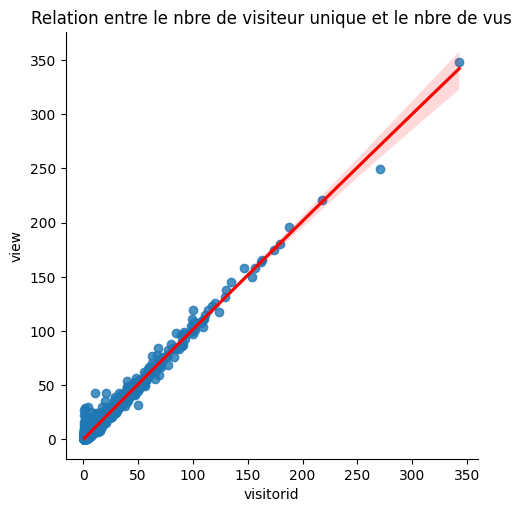

In [ ]:
#relation linéaire entre le nbre de visiteur du produit et les vus
sns.lmplot(x='visitorid', y="view", data=df_final_ag, order = 2, line_kws = {'color': 'red'})
plt.title("Relation entre le nbre de visiteur unique et le nbre de vus")
plt.show()

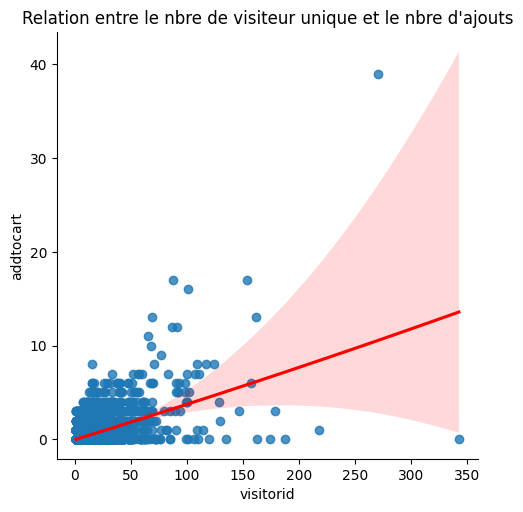

In [ ]:
#relation linéaire entre le nbre de visiteur du produit et les ajouts
sns.lmplot(x='visitorid', y="addtocart", data=df_final_ag, order = 2, line_kws = {'color': 'red'})
plt.title("Relation entre le nbre de visiteur unique et le nbre d'ajouts")
plt.show()

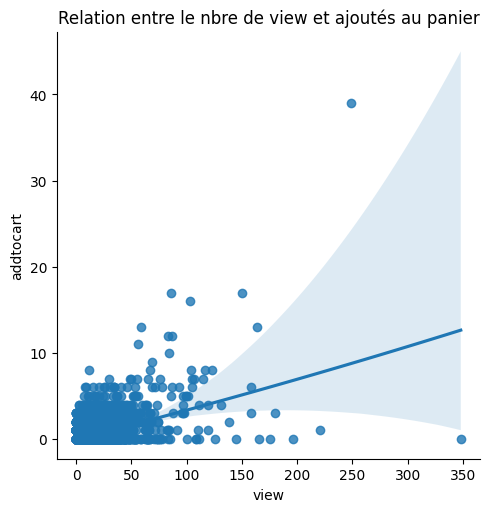

In [ ]:
#relation linéaire entre le nbre de vu et le nbre d'ajout au panier=> sns.lmplot
sns.lmplot(x='view', y="addtocart", data=df_final_ag, order = 2, )
plt.title("Relation entre le nbre de view et ajoutés au panier")
plt.show()

In [ ]:
var_num=df_final_ag[['addtocart','transaction','view','visitorid', 'month']]

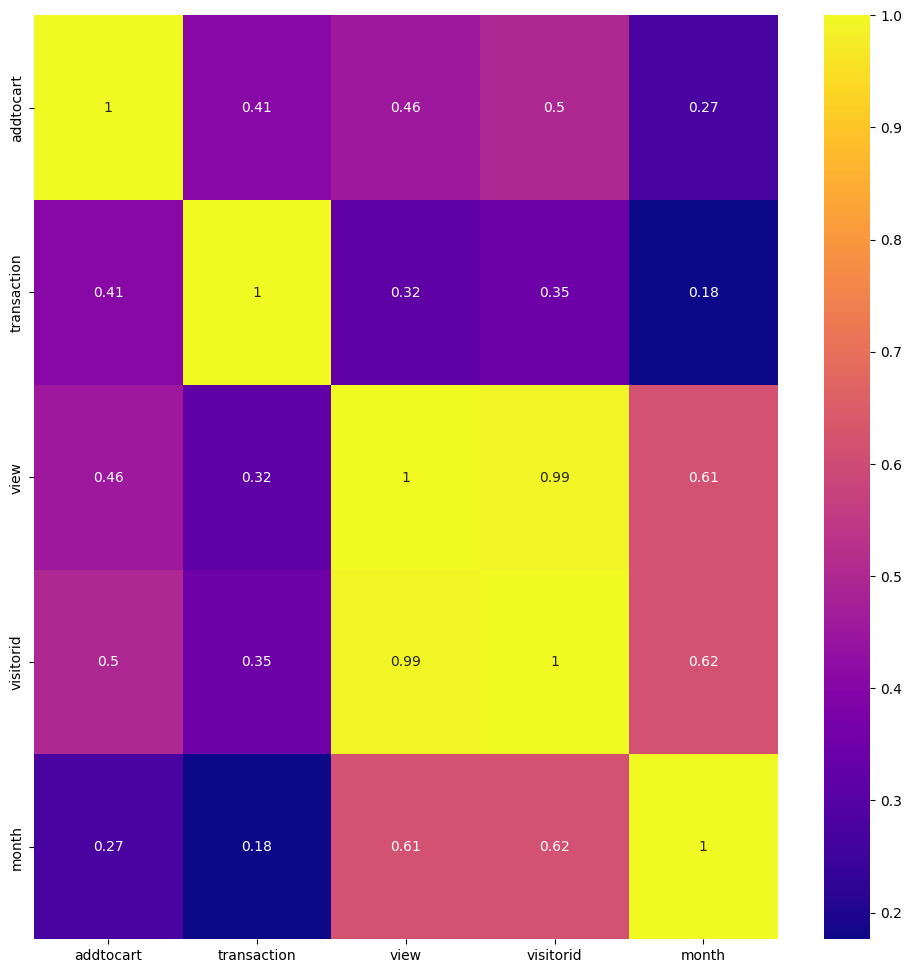

In [ ]:
#De façon logique, il y a une correlation entre le nbre de Il semble avoir une plus grande correlation entre
#correlation variables numerique()
var_num=df_final_ag[['addtocart','transaction','view','visitorid', 'month']]
x=var_num.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(x, annot=True, ax=ax, cmap='plasma');

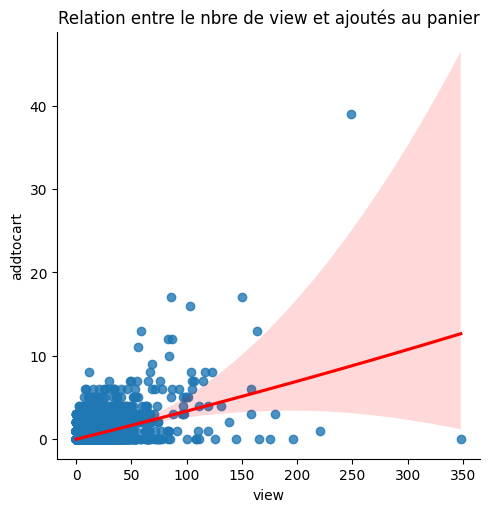

In [ ]:
sns.lmplot(x='view', y="addtocart", data=df_final_ag, order = 2, line_kws = {'color': 'red'})
plt.title("Relation entre le nbre de view et ajoutés au panier")
plt.show()

In [ ]:
df_final_ag.head()
display(df_final_ag.shape)


(76470, 8)

In [ ]:
#clustering pour déterminer des groupes de personnes qui ont des comportements similaires.
#KMEANS
from sklearn.preprocessing import StandardScaler
 # Sélectionner uniquement les colonnes numériques
df_numeric = df_final_ag.drop(['available', 'categoryid','parentid'], axis=1)
df_normalized= df_numeric.copy()

# Normaliser les données
scaler = StandardScaler()
col=['addtocart', 'transaction' ,'view','month','visitorid']
df_normalized.loc[:,col]=scaler.fit_transform(df_normalized[col])
df_numeric.head()

,addtocart,transaction,view,month,visitorid
itemid,,,,,
6,0,0,3,2,3
16,0,0,4,4,4
19,0,0,1,1,1
25,0,0,3,2,3
32,0,0,6,5,6


In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')
distorsion=[]
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(df_normalized)
    distorsion.append(sum(np.min(cdist(df_normalized, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / np.size(df, axis = 0))


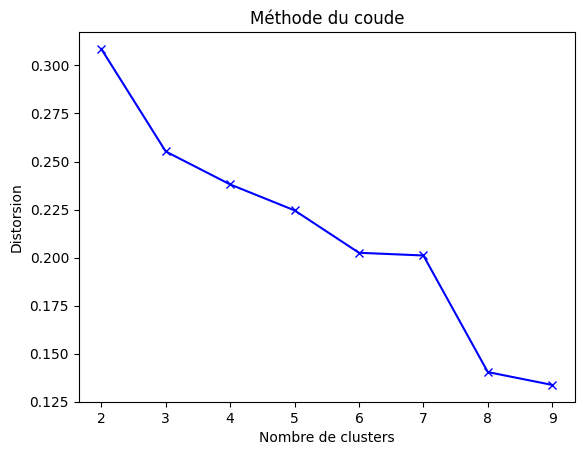

In [ ]:
# Tracer la courbe de la distorsion en fonction du nombre de clusters
plt.plot(range(2, 10), distorsion, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distorsion')
plt.title('Méthode du coude')
plt.show()

In [ ]:
#selon la méthode du coude, le nombre de cluster est de 3
#Entrainement de l'algorithme sur le df, et calcul des positions des K centroïdes et les labels
clf_kmean = KMeans(n_clusters = 3, random_state=42)
clf_kmean=clf_kmean.fit(df_normalized)
centroids = clf_kmean.cluster_centers_
label = clf_kmean.labels_
np.shape(label)


(76470,)

In [ ]:
df_final_ag['cluster_label'] = clf_kmean.labels_
# Interprétation des groupes
# Afficher les statistiques des clusters
cluster_stats = df_final_ag.groupby('cluster_label')[df_numeric.columns].mean()
cluster_stats

,addtocart,transaction,view,month,visitorid
cluster_label,,,,,
0,0.029635,0.007721,1.550394,1.258981,1.534602
1,2.177019,0.804348,43.869565,4.611801,43.563665
2,0.226143,0.077691,7.587959,3.527433,7.459533


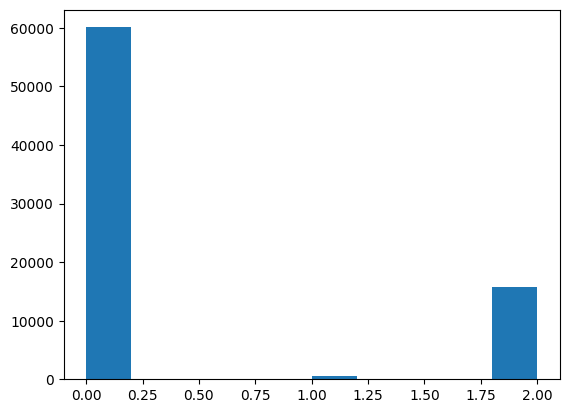

In [ ]:
#Répartition de nos clusters avec la méthodes des Kmeans
#Nous avons près de 60.000 observations dans le clusters n°1, nous avons très peu d'observation dans le cluster n°2
plt.hist(df_final_ag['cluster_label']);

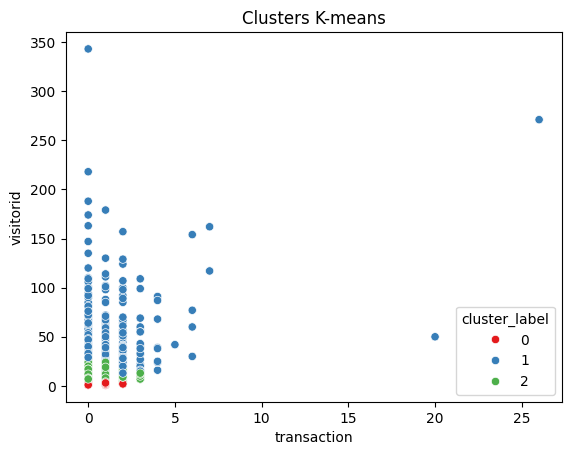

In [ ]:
# Visualisation des groupes
sns.scatterplot(data=df_final_ag, x='transaction', y='visitorid', hue='cluster_label', palette='Set1')
plt.title("Clusters K-means")
plt.show()

In [ ]:
#le cluster n°1 est la cible potentielle pour nous car elle est composée de personnes suceptibles de réaliser des transactions

In [ ]:
#Affichage du df_final
display(df_final_ag.head())

,addtocart,transaction,view,available,categoryid,parentid,month,visitorid,cluster_label
itemid,,,,,,,,,
6,0,0,3,0,1091,573,2,3,0
16,0,0,4,1,333,1497,4,4,2
19,0,0,1,1,1171,938,1,1,0
25,0,0,3,1,1509,620,2,3,0
32,0,0,6,0,1173,805,5,6,2


In [ ]:
#Récuprer les categories de produits qui sont dans le cluster cible
dictag={'categoryid':'unique'}
categ_group=df_final_ag.groupby('cluster_label').agg(dictag)
print("Voici les catégories de produits pris en compte dans le groupe à potentiel")
display(categ_group.iloc[1,0])
np.shape(categ_group.iloc[1,0])
#Nous avons dans le cluster cible 204 categories de produits à potentiel

Voici les catégories de produits pris en compte dans le groupe à potentiel


array([1349, 1650,  606,  972,  959, 1273,  789,  683,  398,  707,  969,
        858, 1037,    5, 1192, 1375, 1279, 1051, 1483, 1277,    1, 1173,
        124,  229, 1373, 1006,  596,  406,  535,  342,   84, 1221,  499,
       1265,  167, 1295,  646,  282,  626, 1584,  694, 1244, 1286, 1474,
        451, 1415, 1625, 1135,  926,  720, 1317, 1219,  446,  333, 1384,
       1542,  804, 1339, 1613, 1018,  411, 1120, 1393, 1089, 1172,   51,
        589,   48,  818, 1390, 1296,   34,  445, 1659, 1404,  928, 1049,
       1220,  782,  936, 1364,  191,  202,   56, 1529,  984,  434, 1305,
        921, 1263,  106, 1325,   57,  684,  568, 1047,  239,  973,  417,
       1205,  421,  665, 1421, 1188,  230,  356,  427,  242,  195,  340,
       1526,  324,  656,  862, 1235, 1248,  828, 1385,  730,  821,  224,
        529,  509, 1060, 1589, 1402,  487,  533, 1578,  819,  471,  463,
       1558,   35, 1642,   64, 1163, 1544,  895,  299,  642,  618,  228,
        558,   29,  575,   65,  159, 1150, 1231,  1

(204,)

In [ ]:
categ_group

,categoryid
cluster_label,
0,"[1091, 1171, 1509, 1526, 1007, 586, 237, 1186,..."
1,"[1349, 1650, 606, 972, 959, 1273, 789, 683, 39..."
2,"[333, 1173, 84, 1080, 646, 1006, 816, 959, 586..."


In [ ]:
#CAH
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples

# Initialisaion de la figrue
#plt.figure(figsize=(20, 10))
# Génération de la matrice des liens
#Z = linkage(df_normalized, method = 'ward', metric = 'euclidean')
# Affichage du dendrogramme
#plt.title("Dendrogramme CAH")
#dendrogram(Z, labels = df_normalized.index, leaf_rotation = 90., color_threshold = 290)
#plt.show()

In [ ]:
#DBSCAN
from sklearn.cluster import DBSCAN

# Instancier l'algorithme DBSCAN avec des valeurs d'epsilon et min_samples appropriées.
##dbscan = DBSCAN(eps=0.5, min_samples=5)

# Adapter le modèle aux données.
#dbscan.fit(df_normalized)

# Les étiquettes de cluster sont disponibles dans l'attribut 'labels_'.
#cluster_labels_dbscan = dbscan.labels_

# Ajouter les labels au DataFrame original
#df_final_ag['Cluster_label_DBscan'] = cluster_labels_dbscan

# Afficher le DataFrame avec les clusters.
#df_final_ag.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

In [ ]:
#Modélisation
#notre variable cible est la variable transaction
#nous allons faire 2 modèles de regression et 3 modèles de classification
#Modèles de regression: Régression linéaire, arbre de regression
#Modèles de classification: Randomforest, arbre de classification(DecisionTreeClassifier), SVM

In [ ]:
#création de df pour classification
df_final_ag_clf=df_final_ag
df_final_ag_clf.loc[df_final_ag_clf.transaction != 0]=1

In [ ]:
df_final_ag_clf.head()

,addtocart,transaction,view,available,categoryid,parentid,month,visitorid,cluster_label
itemid,,,,,,,,,
6,0,0,3,0,1091,573,2,3,0
16,0,0,4,1,333,1497,4,4,2
19,0,0,1,1,1171,938,1,1,0
25,0,0,3,1,1509,620,2,3,0
32,0,0,6,0,1173,805,5,6,2


In [ ]:
df_final_ag_clf.transaction.value_counts()

0    74581
1     1889
Name: transaction, dtype: int64

In [ ]:
#Séparation des données en un DataFrame feats contenant les variables explicatives et target contenant la variable transaction
target=df_final_ag_clf.transaction
feats=df_final_ag_clf.drop('transaction', axis=1)

In [ ]:
#création d'un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% des données.
X_train, X_test,y_train,y_test=train_test_split(feats,target,test_size=0.2,random_state=42)

In [ ]:
# standardisation des colonnes numériques
col=['addtocart','view','month','visitorid']
scaler=StandardScaler()
X_train.loc[:,col]=scaler.fit_transform(X_train[col])
X_test.loc[:,col]=scaler.transform(X_test[col])

In [ ]:
#scaler=StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.transform(X_test)

In [ ]:
#Création du modèle de classification SVM, l'entrainement et le score
svm = SVC(gamma='scale')
svm.fit(X_train,y_train)
print("score du svm obtenu sur l'ensemble de test", svm.score(X_test,y_test))

score du svm obtenu sur l'ensemble de test 0.9979076762128939


In [ ]:
#nous avons un bon score pour notre modèle, mais est-ce que notre modèle réussit vraiment à prédire les 2 classes?
#Pour le savoir, nous allons faire des prédictions de notre modèle sur les données de test,
#et afficher la matrice de confusion correspondante et le rapport d'évaluation du modèle
y_pred_svm=svm.predict(X_test)
display(pd.crosstab(y_test,y_pred_svm,rownames=['classe reelle'], colnames=['classe predite']))
print(classification_report(y_test, y_pred_svm))

classe predite,0,1
classe reelle,,
0,14867,32
1,0,395


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14899
           1       0.93      1.00      0.96       395

    accuracy                           1.00     15294
   macro avg       0.96      1.00      0.98     15294
weighted avg       1.00      1.00      1.00     15294



In [ ]:
#nous voyons ici que le modèle a des scores trop élevés

In [ ]:
#utilisation des méthodes Oversampling / under sampling pour améliorer les scores
## methode Oversampling
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('classe Oversampling aléatoire :', dict(pd.Series(y_ro).value_counts()))

smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('classes SMOTE :', dict(pd.Series(y_sm).value_counts()))

classe Oversampling aléatoire : {0: 59682, 1: 59682}
classes SMOTE : {0: 59682, 1: 59682}


In [ ]:
# Entrainement avec la méthodes RandomOversampler
svm_ros = SVC(gamma='scale')
svm_ros.fit(X_ro, y_ro)
y_pred_ros=svm_ros.predict(X_test)

display(pd.crosstab(y_test,y_pred_ros,rownames=['classe reelle'], colnames=['classe predite']))
print(classification_report_imbalanced(y_test, y_pred_ros))



classe predite,0,1
classe reelle,,
0,14869,30
1,0,395


                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00     14899
          1       0.93      1.00      1.00      0.96      1.00      1.00       395

avg / total       1.00      1.00      1.00      1.00      1.00      1.00     15294



In [ ]:
#les méthodes undersampling
## Réechantionner les echantillons avec la méthode RandomUnderSampler
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print('classe Undersampling aléatoire :', dict(pd.Series(y_ru).value_counts()))

## Réechantionner les echantillons avec la méthode ClusterCentroids
clC = ClusterCentroids()
X_cc, y_cc= rUs.fit_resample(X_train, y_train)
print('classe ClusterCentroids aléatoire :', dict(pd.Series(y_cc).value_counts()))

classe Undersampling aléatoire : {0: 1494, 1: 1494}
classe ClusterCentroids aléatoire : {0: 1494, 1: 1494}


In [ ]:
#Entrainement avec la méthode RandomUndersampler
svm_ru = SVC(gamma='scale')
svm_ru.fit(X_ru, y_ru)

y_pred_ru = svm_ru.predict(X_test)
print(pd.crosstab(y_test, y_pred_ru))

print(classification_report_imbalanced(y_test, y_pred_ru))

col_0            0    1
transaction            
0            14861   38
1                0  395
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00     14899
          1       0.91      1.00      1.00      0.95      1.00      1.00       395

avg / total       1.00      1.00      1.00      1.00      1.00      1.00     15294



In [ ]:
#Entrainement avec la méthode ClusterCentroids

svm_cc = SVC(gamma='scale')
svm_cc.fit(X_cc, y_cc)

y_pred_cc = svm_cc.predict(X_test)
print(pd.crosstab(y_test, y_pred_cc))

print(classification_report_imbalanced(y_test, y_pred_cc))

col_0            0    1
transaction            
0            14857   42
1                0  395
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00     14899
          1       0.90      1.00      1.00      0.95      1.00      1.00       395

avg / total       1.00      1.00      1.00      1.00      1.00      1.00     15294



In [ ]:
#Appliquons à présent la méthode qui donne une prediction d'appartenance ou non à une classe
svm_pro = SVC(probability=True, gamma='scale')
svm_pro.fit(X_ru, y_ru)
threshold = 0.5
probs = svm_pro.predict_proba(X_test)
pred_class = (probs[:,1]>=threshold).astype('int')
pd.crosstab(y_test, pred_class)

col_0,0,1
transaction,,
0,14861,38
1,0,395


In [ ]:
#Création du modèle de classification RandomForest, l'entrainement et le score
clf_rand=RandomForestClassifier(random_state=22)
clf_rand.fit(X_train,y_train)

print("score du RandomForest obtenu sur l'ensemble de test", clf_rand.score(X_test,y_test))

score du RandomForest obtenu sur l'ensemble de test 1.0


In [ ]:
#Prédiction avec le modèle randforest et le classification report
y_pred2=clf_rand.predict(X_test)
display(pd.crosstab(y_test,y_pred2,rownames=['classe reelle'], colnames=['classe predite']))
print(classification_report(y_test, y_pred2))

classe predite,0,1
classe reelle,,
0,14899,0
1,0,395


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14899
           1       1.00      1.00      1.00       395

    accuracy                           1.00     15294
   macro avg       1.00      1.00      1.00     15294
weighted avg       1.00      1.00      1.00     15294



In [ ]:
#les méthodes undersampling  pour le rééchantionnage
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print('classe Undersampling aléatoire :', dict(pd.Series(y_ru).value_counts()))

clC = ClusterCentroids()
X_cc, y_cc= rUs.fit_resample(X_train, y_train)
print('classe ClusterCentroids aléatoire :', dict(pd.Series(y_cc).value_counts()))

In [ ]:
#Entrainement avec la méthode RandomUnderSampler et affichage des scores
clf_tree_ru=DecisionTreeClassifier()
clf_tree_ru.fit(X_ru, y_ru)

y_pred_tree_ru = clf_tree_ru.predict(X_test)
print(pd.crosstab(y_test, y_pred_tree_ru))

print(classification_report_imbalanced(y_test, y_pred_tree_ru))

In [ ]:
#Création du modèle de regression logistics, l'entrainement et le score
from sklearn.linear_model import LogisticRegression
clf_log=LogisticRegression(random_state=22, max_iter=2000)
clf_log.fit(X_train,y_train)

print("score du modèle de regression logistics obtenu sur l'ensemble de test", clf_log.score(X_test,y_test))

score du modèle de regression logistics obtenu sur l'ensemble de test 1.0


In [ ]:
#Prédiction avec le modèle regression logistics et le rapport de classification
y_pred3=clf_log.predict(X_test)
display(pd.crosstab(y_test,y_pred3,rownames=['classe reelle'], colnames=['classe predite']))
print(classification_report(y_test, y_pred3))

classe predite,0,1
classe reelle,,
0,14899,0
1,0,395


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14899
           1       1.00      1.00      1.00       395

    accuracy                           1.00     15294
   macro avg       1.00      1.00      1.00     15294
weighted avg       1.00      1.00      1.00     15294



In [ ]:
#Nous allons grâce à la grille de recherche choisissir le meilleur ensemble d'hyperparamètres
clf_log = LogisticRegression(random_state=22, max_iter=2000)
clf_rand = RandomForestClassifier(random_state=22)
svm = SVC(random_state=22)


param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                  'min_samples_leaf': [1, 3, 5],
                  'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'kernel': ['rbf'], 'C': np.logspace(-4, 4, 9), 'gamma': np.logspace(-4, 0, 4)},
                  {'kernel': ['linear'], 'C': np.logspace(-4, 4, 9)}]

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
gridcvs = {}
for pgrid, clf, name in zip((param_grid_lr, param_grid_rf, param_grid_svc),
                            (clf_log, clf_rand, svm),
                            ('LogisticRegression', 'RF', 'SVM')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv

In [ ]:
outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_train, y_train, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

LogisticRegression: outer accuracy 100.00 +/- 0.00
RF: outer accuracy 100.00 +/- 0.00
SVM: outer accuracy 100.00 +/- 0.00


In [ ]:
from sklearn.metrics import accuracy_score

final_clf = gridcvs['LogisticRegression']
final_clf.fit(X_train, y_train)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

In [ ]:
# Toutes les méthodes de rééchantionnage utilisées n'ont pas un impact sur les résultats parce que au sein de la variable cible, nous avons une classe prédominante par rapport à la 2ième
#nous proposons l'utilisation du modèle IsolationForest

# Création du modèle d'Isolation Forest
isolation_forest = IsolationForest(contamination=0.02, random_state=42)

# Entrainement du  modèle sur les X_train
isolation_forest.fit(X_train)

# Prediction d'anomalies sur l'échnatillon test
y_pred_iso = isolation_forest.predict(X_test)


In [ ]:
y_pred_iso
unique, counts = np.unique(y_pred_iso, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
# Il semblerait que les -1 représentent la classe minoritaire cad les transactions
#remplaçons les valeurs 1 par 0
y_pred_iso[y_pred_iso== 1] = 0
#et les -1 par 1
y_pred_iso[y_pred_iso== -1] = 1

# Regardons les prédictions faites par le modèle isolation Forest
y_pred_iso
unique, counts = np.unique(y_pred_iso, return_counts=True)
print(np.asarray((unique, counts)).T)

#regardons la répartition de notre y_test
y_test.value_counts()

In [ ]:
#Evaluation du modèle d'Isolation Forest
display(pd.crosstab(y_test,y_pred_iso,rownames=['classe reelle'], colnames=['classe predite']))
print(classification_report(y_test, y_pred_iso))

In [ ]:
# Calculate ROC curve and AUC
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
fpr_iso, tpr_iso, _ = roc_curve(y_test, y_pred_iso)
roc_auc_iso = auc(fpr_iso, tpr_iso)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, color='red', lw=2, label=f'Isolation Forest (AUC = {roc_auc_iso:.2f})')
plt.plot(fpr_svm, tpr_svm, color='navy', lw=2, label=f'One-Class SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Création du modème  One-Class SVM
one_class_svm = OneClassSVM(nu=0.05)

# Entrainement du  modèle sur les X_train (One-Class SVM est une méthode non supervisé)
one_class_svm.fit(X_train)

# Prediction d'anomalies sur l'échnatillon tes
y_pred_svm = one_class_svm.predict(X_test)

In [ ]:
y_pred_svm
unique, counts = np.unique(y_pred_svm, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
# Il semblerait que les -1 représentent la classe minoritaire cad les transactions
#remplaçons les valeurs 1 par 0
y_pred_svm[y_pred_svm== 1] = 0
#et les -1 par 1
y_pred_svm[y_pred_svm== -1] = 1

# Regardons les prédictions faites par le modèle One-Class SVM
y_pred_svm
unique, counts = np.unique(y_pred_svm, return_counts=True)
print(np.asarray((unique, counts)).T)

#regardons la répartition de notre y_test
y_test.value_counts()

In [ ]:
#Evaluation du modèle One-Class SVM
display(pd.crosstab(y_test,y_pred_svm,rownames=['classe reelle'], colnames=['classe predite']))
print(classification_report(y_test, y_pred_svm))

In [ ]:
#Modèles de Regression
#création de df pour regression
df_final_ag_reg=df_final_ag
df_final_ag_reg.transaction.value_counts()

In [ ]:
#Séparation des données en un DataFrame feats contenant les variables explicatives et target contenant la variable transaction
target2=df_final_ag_reg.transaction
feats2=df_final_ag_reg.drop('transaction', axis=1)

In [ ]:
#création d'un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% des données.
X_train2, X_test2,y_train2,y_test2=train_test_split(feats2,target2,test_size=0.2,random_state=42)

In [ ]:
# standardisation des colonnes numériques

scaler=StandardScaler()
X_train2=scaler.fit_transform(X_train2)
X_test2=scaler.transform(X_test2)

In [ ]:
#Création du modèle de regression linéaire, l'entrainement et le score
reg_li=LinearRegression()
reg_li.fit(X_train2,y_train2)

print("score R2 obtenu sur l'ensemble de test", reg_li.score(X_test2,y_test2))

In [ ]:
#Le R2 pour notre modèle de regession linéaire est faible
#prédiction
y_pred4=reg_li.predict(X_test2)

In [ ]:
#affichage du graphe de regression linéaire
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
plt.scatter(y_pred4, y_test2, c='green')
plt.plot((y_test2.min(), y_test2.max()), (y_test2.min(), y_test2.max()), color = 'red')
plt.xlabel("prediction")
plt.ylabel("vrai valeur")
plt.title('Régression Linéaire pour le nbre de transaction')
plt.show()

In [ ]:
#notre modèle n'est pas linéaire

In [ ]:
#Création du modèle d'arbre de regression, l'entrainement et le score
mod_dec=DecisionTreeRegressor()
mod_dec.fit(X_train2,y_train2)

print('score pour train":', mod_dec.score(X_train2,y_train2))
print('score pour test":',mod_dec.score(X_test2,y_test2))

In [ ]:
#un score sur l'entrainement est bon
#regardons l'importance des variables
import matplotlib.pyplot as plt
%matplotlib inline
feat_importances = pd.DataFrame(data=mod_dec.feature_importances_, index=feats2.columns,columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot.bar(figsize=(8,6), color='y');

In [ ]:
#notre modèle n'a pris en compte qu'une seule variable de parentid :)